In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

### 1. Згенерувати випадковий процес за різницевим рівнянням
### x(n)= θ(n)+x(n-1)-0.5*x(n-2),
### де θ(n) – нормальний білий шум з нулевим математичним очікуванням и одиничною дисперсією. Початковий стан x(-1)=x(-2)=0. Для аналізу виділити інтервал тривалістю 4096 відліків, вільний від перехідного процесу.

In [2]:
def generate_signal(N):
    theta = np.random.normal(loc=0,scale=1,size=(N,))
    X_n = np.zeros_like(theta)
    for i in range(N):
        X_n[i] = theta[i] +X_n[i-1] - 0.5*X_n[i-2]

    return theta,X_n

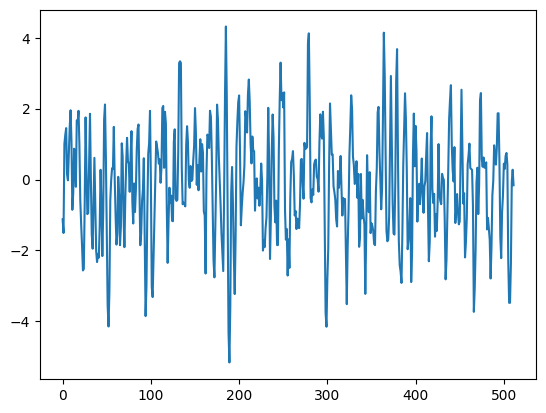

In [3]:
theta, X_n = generate_signal(512)
plt.plot(X_n)

In [4]:
def create_sub_sequences(X_main,D,M):
    Xrs = []
    N = len(X_main)
    r = 1
    while M+D*(r-1)<=N:
        Xrs.append(X_n[D*(r-1):D*(r-1)+M])
        r+=1
    return Xrs

#Xrs = create_sub_sequences(X_n,128,128)

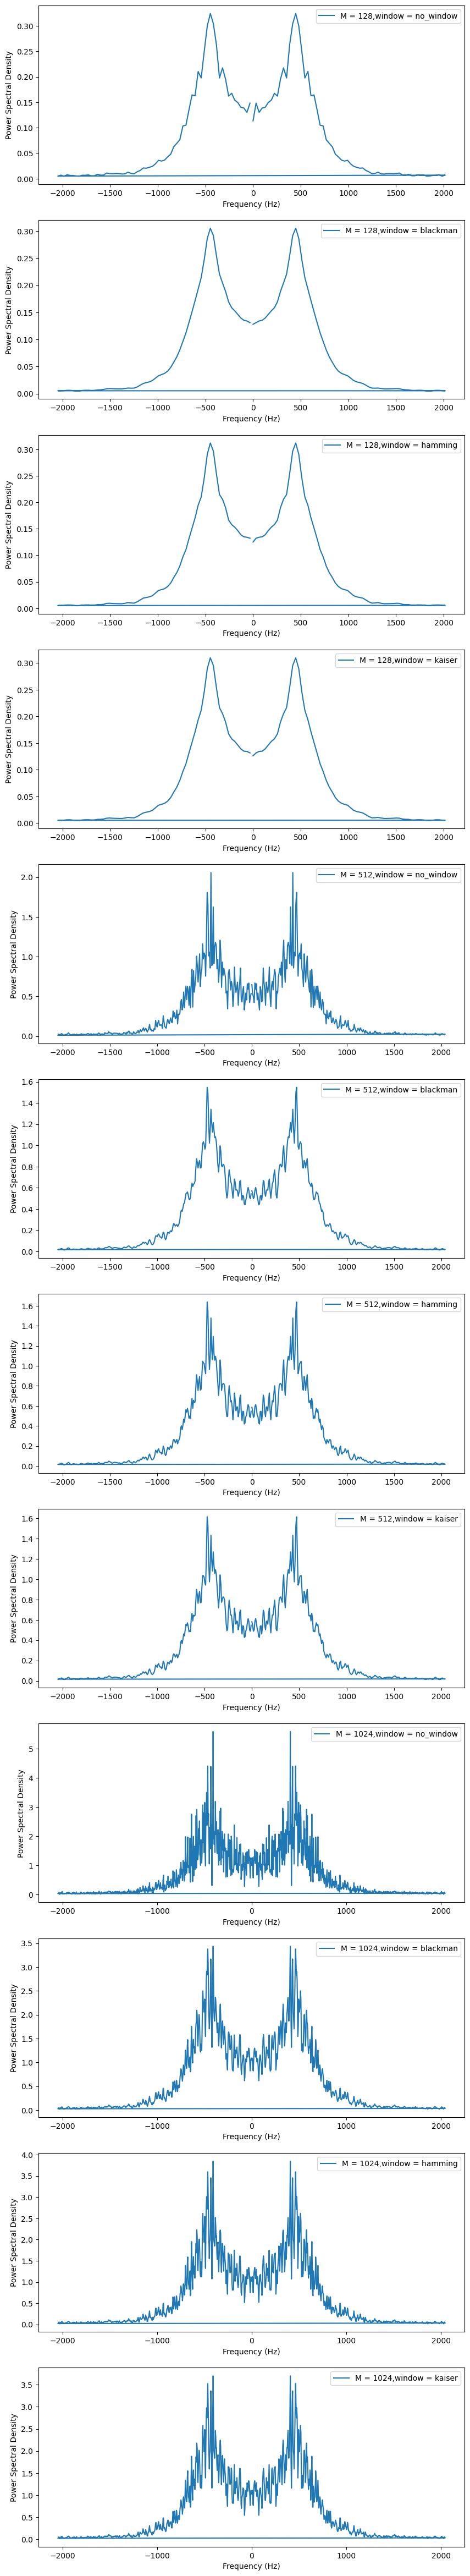

In [7]:
from scipy.signal.windows import blackman,hamming,kaiser

N = 4096
Ms = [128,512,1024]
Ds = {'0%_overlap_between_subseqs':lambda M:M} #0% overlap betweeen subsequences
window_functions = {'no_window': lambda seq,M:(np.ones(shape=(M)),seq),
                    'blackman':lambda seq,M:(blackman(M),blackman(M)*seq),
                    'hamming':lambda seq,M:(hamming(M),hamming(M)*seq),
                    'kaiser':lambda seq,M:(kaiser(M,beta=6),kaiser(M,beta=6)*seq)
                    }
theta, X_n = generate_signal(N)
fig,ax = plt.subplots(12,figsize=(10,60))
ax_i = 0
for M in Ms:
    for d_notation,d_func in Ds.items():
        for window_name,window_func in window_functions.items():
            D = d_func(M=M)
            Xrs = create_sub_sequences(X_main=X_n,D=D,M=M)
            periodogram_cumulative_sum = np.zeros(shape=(M,))
            K = len(Xrs)
            for Xr in Xrs:
                #window_energy = np.sum(window**2)
                #periodogram = np.abs(fft(Xr_window_modified))**2/window_energy
                rxx = np.correlate(Xr,Xr,mode='same')
                window,rxx_window_modified = window_func(seq=rxx,M=M)
                Pxx = np.abs(fft(rxx_window_modified))
                periodogram_cumulative_sum+=Pxx
            PSD_final = periodogram_cumulative_sum/(K*N)
            xf = fftfreq(M,1/N)
            cur_ax = ax[ax_i]
            cur_ax.plot(xf,PSD_final, label=f'M = {M},window = {window_name}')
            cur_ax.set_xlabel('Frequency (Hz)')
            cur_ax.set_ylabel('Power Spectral Density')
            #cur_ax.title('Power Spectral Density with Varying Window Sizes')
            cur_ax.legend()
            ax_i +=1